In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datenspende.utils import query_ch_df, query_pg_df
import datetime
from datetime import date
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import os
import glob
from functools import reduce

In [2]:
path = os.getcwd()+'/u_fat/'
csv_files = glob.glob(os.path.join(path, "*.csv"))

fatu = []
demo_info = []
fuid = []
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f, index_col = 0)
    #for var in ['sleep', 'hr', 'steps']:
    #    if var not in df.columns:
    #        df[var] = np.nan
    fatu.append(df)
    demo_info.append(f.split("/")[-1].split('.')[0])
    fuid.append(int(f.split("/")[-1].split('.')[1][1:])) 
      
fsex = [re.split('(\d+)',demo_info[i])[0] for i in range(len(demo_info))]
fage = [int(re.split('(\d+)',demo_info[i])[1]) for i in range(len(demo_info))] 

In [3]:
path = os.getcwd()+'/u_shb/'
csv_files = glob.glob(os.path.join(path, "*.csv"))

shbu = []
demo_info = []
suid = []
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f, index_col = 0)
    #for var in ['sleep', 'hr', 'steps']:
    #    if var not in df.columns:
    #        df[var] = np.nan
    shbu.append(df)
    demo_info.append(f.split("/")[-1].split('.')[0])
    suid.append(int(f.split("/")[-1].split('.')[1][1:])) 
      
ssex = [re.split('(\d+)',demo_info[i])[0] for i in range(len(demo_info))]
sage = [int(re.split('(\d+)',demo_info[i])[1]) for i in range(len(demo_info))] 

In [24]:
[ i for i in suid if i in fuid]

[23542, 8703]

## RHR HR

In [4]:
def sliding_window(elements, window_size):
    wi_days = []
    for i in range(len(elements)- window_size + 1):
        wi_days.append(elements[i:i+window_size])         
    return wi_days

In [5]:
def get_md(subd):
    subd = subd.copy()
    subd['start'] = pd.to_datetime(subd['start'])
    subd = subd[subd['start'].notna()]
    if len(subd) > 0:
        night = subd[(subd['start'].dt.time < pd.to_datetime('07:00:00').time())&((subd['steps'].isna())|(subd['steps']==0))]['hr'].dropna()
        day = subd[(subd['start'].dt.time >= pd.to_datetime('07:00:00').time())&((subd['steps'].notna())&(subd['steps']!=0))]['hr'].dropna()
        rhr_rel = subd[(subd['start'].dt.time < pd.to_datetime('07:00:00').time())&((subd['steps'].isna())|(subd['steps']==0))]['% of MHR'].dropna()
        if len(day) >= 100 and len(night) >= 100:
            return night.mean(), night.std(), day.mean(), day.std(), rhr_rel.mean()
        else:
            return 0,0,0,0,0
    else:
        return 0,0,0,0,0

In [6]:
mins = []
maxs = []
minw = []
maxw = []
for df in fatu:
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df['day_totest'] = df['date'] - df['dt']
    mins.append(df['day_totest'].min())
    maxs.append(df['day_totest'].max())
    minw.append(df['week_totest'].min())
    maxw.append(df['week_totest'].max())

In [7]:
for df in shbu:
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df['day_totest'] = df['date'] - df['dt']
    mins.append(df['day_totest'].min())
    maxs.append(df['day_totest'].max())
    minw.append(df['week_totest'].min())
    maxw.append(df['week_totest'].max())

In [8]:
fu_day_mean = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(fatu)))
fu_night_mean = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(fatu)))
fu_diff = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(fatu)))
fu_rhr_rel = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(fatu)))

In [9]:
for u in range(len(fatu)):
    df = fatu[u]
    mis_row = []
    for dt in [d for d in pd.date_range(start = df['date'].min(), end = df['date'].max()).difference(df.index) if d not in df['date'].unique()]:
        mis_row.append([
            np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, dt, np.nan, np.nan, np.nan, dt - df['dt'].unique()[0], np.nan, np.nan, np.nan])
    if len(mis_row) > 0:
        df = df.append(pd.DataFrame(data=mis_row, columns=df.columns))
    df = df.sort_values(by='date')
    
    #df['day_totest'] = df['date'] - df['dt']
    wi_list = sliding_window(df['date'].unique(),7)
    dtt_list = sliding_window(df['day_totest'].unique(),7)
    for wi in range(len(wi_list)):
        nm, ns, dm, ds, rhrr = get_md(df[df['date'].isin(wi_list[wi])])
        fu_day_mean.loc[fu_day_mean.index.isin(dtt_list[wi]),u] =  dm
        fu_night_mean.loc[fu_night_mean.index.isin(dtt_list[wi]),u] =  nm
        fu_rhr_rel.loc[fu_rhr_rel.index.isin(dtt_list[wi]),u] =  rhrr
        if dm != 0:
            fu_diff.loc[fu_night_mean.index.isin(dtt_list[wi]),u] = (dm - nm)/dm
        

In [12]:
su_day_mean = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(shbu)))
su_night_mean = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(shbu)))
su_diff = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(shbu)))
su_rhr_rel = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(shbu)))

for u in range(len(shbu)):
 
    df = shbu[u]
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df['day_totest'] = df['date'] - df['dt']
    mis_row = []
    for dt in [d for d in pd.date_range(start = df['date'].min(), end = df['date'].max()).difference(df.index) if d not in df['date'].unique()]:
        mis_row.append([
            np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, dt, np.nan, np.nan, np.nan, dt - df['dt'].unique()[0], np.nan, np.nan, np.nan])
    if len(mis_row) > 0:
        df = df.append(pd.DataFrame(data=mis_row, columns=df.columns))
    df = df.sort_values(by='date')

    #df['day_totest'] = df['date'] - df['dt']
    wi_list = sliding_window(df['date'].unique(),7)
    dtt_list = sliding_window(df['day_totest'].unique(),7)
    for wi in range(len(wi_list)):
        nm, ns, dm, ds, rhrr = get_md(df[df['date'].isin(wi_list[wi])])
        su_day_mean.loc[su_day_mean.index.isin(dtt_list[wi]),u] =  dm
        su_night_mean.loc[su_night_mean.index.isin(dtt_list[wi]),u] =  nm
        su_rhr_rel.loc[su_rhr_rel.index.isin(dtt_list[wi]),u] =  rhrr
        if dm != 0:
            su_diff.loc[su_night_mean.index.isin(dtt_list[wi]),u] = (dm - nm)/dm

In [13]:
fu_diff = fu_diff[(fu_diff.index >= datetime.timedelta(days = -274)) &(fu_diff.index <= datetime.timedelta(days = 286))]
su_diff = su_diff[(su_diff.index >= datetime.timedelta(days = -274)) &(su_diff.index <= datetime.timedelta(days = 286))]
fu_rhr_rel = fu_rhr_rel[(fu_rhr_rel.index >= datetime.timedelta(days = -274)) &(fu_rhr_rel.index <= datetime.timedelta(days = 286))]
su_rhr_rel = su_rhr_rel[(su_rhr_rel.index >= datetime.timedelta(days = -274)) &(su_rhr_rel.index <= datetime.timedelta(days = 286))]

In [14]:
wks = []
for w in range(-40,41):
    for d in range(7):
        wks.append(w)

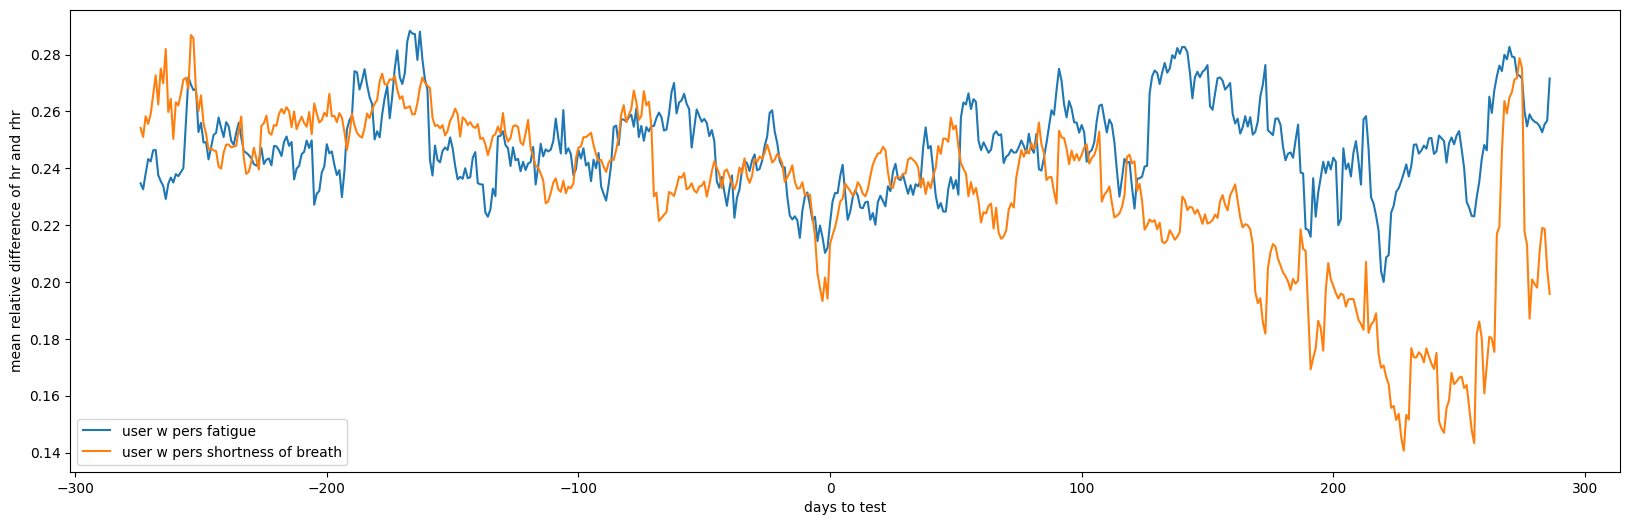

In [15]:
plt.figure(figsize=(20,6))
plt.plot(fu_diff.index.days,fu_diff.mean(axis=1));

plt.plot(su_diff.index.days,su_diff.mean(axis=1));
#plt.errorbar(mu_diff.index.days,mu_diff.mean(axis=1),yerr=mu_diff.std(axis=1)/np.sqrt(mu_diff.notna().sum(axis=1).values), fmt=".")
#plt.xticks( df_cu_diff.index,labels=[str(i) for i in df_cu_diff.index.days//7]);
plt.xlabel('days to test')
plt.legend(['user w pers fatigue', 'user w pers shortness of breath'])
plt.ylabel('mean relative difference of hr and rhr');

In [16]:
su_rhr_rel = su_rhr_rel.replace(0, np.nan)

In [17]:
fu_rhr_rel = fu_rhr_rel.replace(0, np.nan)

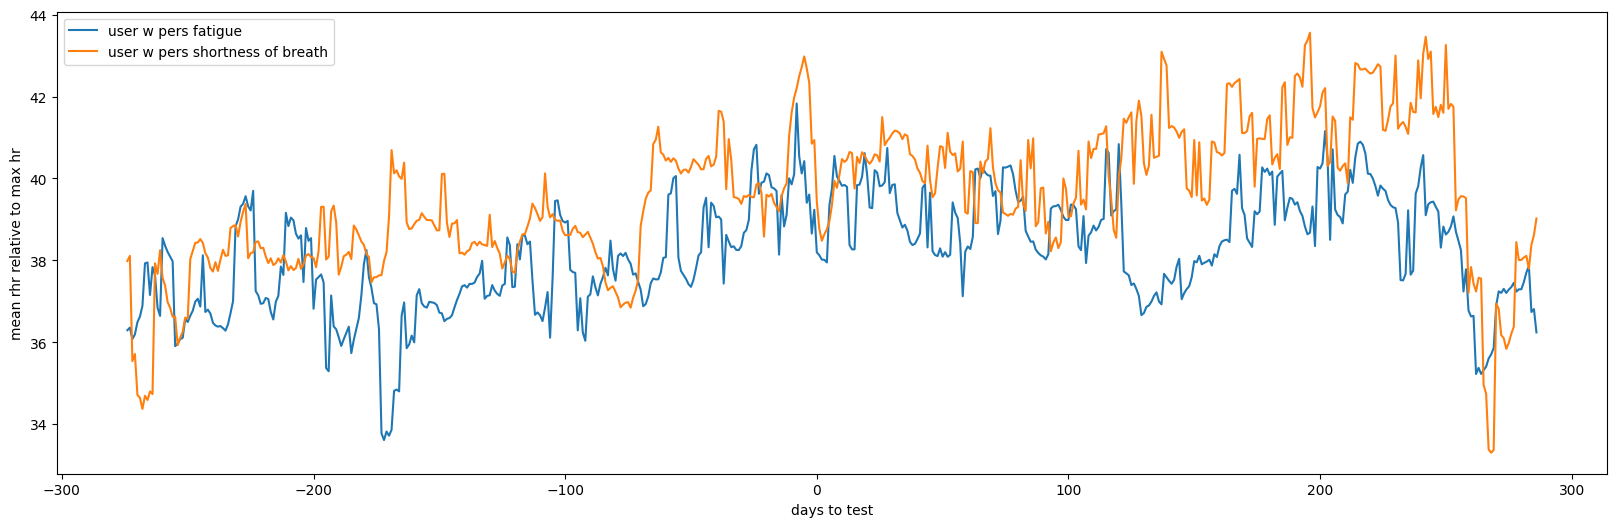

In [21]:
plt.figure(figsize=(20,6))
plt.plot(fu_rhr_rel.index.days,fu_rhr_rel.mean(axis=1) );

plt.plot(su_rhr_rel.index.days,su_rhr_rel.mean(axis=1) );
#plt.errorbar(mu_diff.index.days,mu_diff.mean(axis=1),yerr=mu_diff.std(axis=1)/np.sqrt(mu_diff.notna().sum(axis=1).values), fmt=".")
#plt.xticks( df_cu_diff.index,labels=[str(i) for i in df_cu_diff.index.days//7]);
plt.xlabel('days to test')
plt.legend(['user w pers fatigue', 'user w pers shortness of breath'])
plt.ylabel('mean rhr relative to max hr');

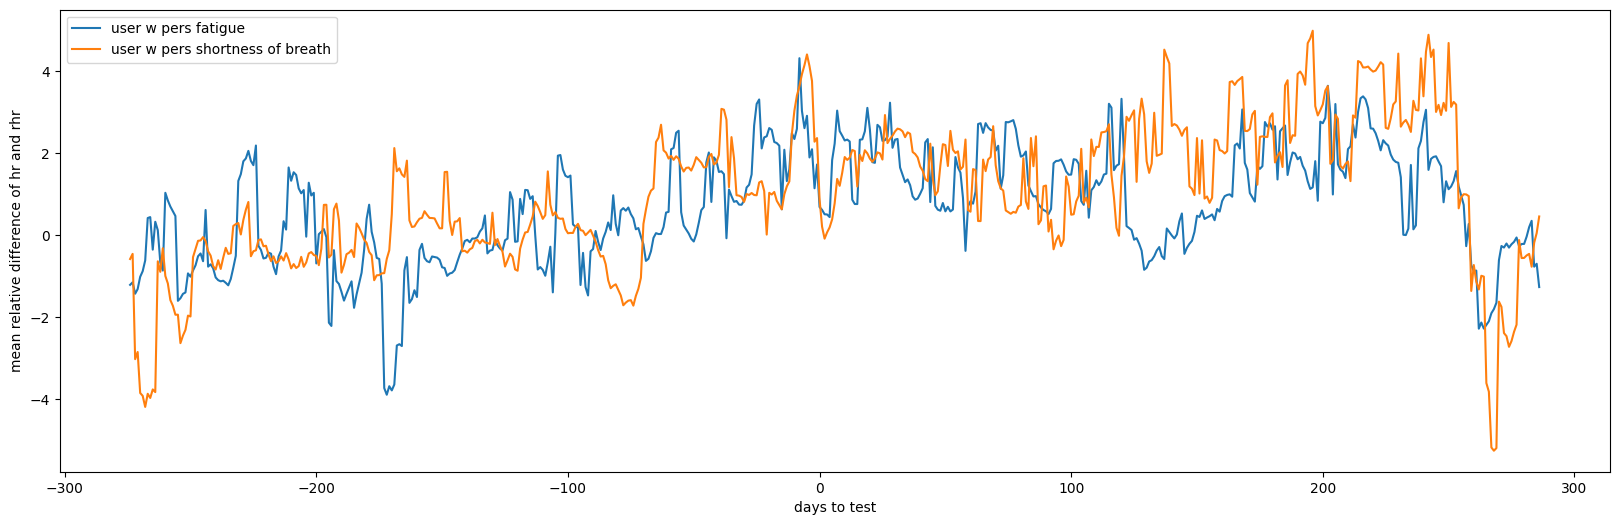

In [18]:
plt.figure(figsize=(20,6))
plt.plot(fu_rhr_rel.index.days,fu_rhr_rel.mean(axis=1)-fu_rhr_rel[fu_rhr_rel.index.days < -14].mean(axis=1).mean());

plt.plot(su_rhr_rel.index.days,su_rhr_rel.mean(axis=1)-su_rhr_rel[su_rhr_rel.index.days < -14].mean(axis=1).mean());
#plt.errorbar(mu_diff.index.days,mu_diff.mean(axis=1),yerr=mu_diff.std(axis=1)/np.sqrt(mu_diff.notna().sum(axis=1).values), fmt=".")
#plt.xticks( df_cu_diff.index,labels=[str(i) for i in df_cu_diff.index.days//7]);
plt.xlabel('days to test')
plt.legend(['user w pers fatigue', 'user w pers shortness of breath'])
plt.ylabel('mean relative difference of hr and rhr');

## HR STEPS

In [97]:
f_agg = []
for df in fatu:
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    # group by day and hourly - sum up steps and take mean of heart rate
    # per day 24 time bins with steps summed up and mean of heart rate

    #for du in range(len(df_lcu[0])): 
    d = df.copy()
    d['start'] = pd.to_datetime(d['start'])
    d['steps'] = d['steps'].fillna(0)
    d['steps'] = d['steps'] + 1

    df_aggv = pd.merge(d[['start','hr','rhr', '% of MHR', 'sleep']].set_index('start').resample('60min').mean().reset_index(),d[['start','steps']].set_index('start').resample('30min').sum().reset_index(),how='outer',on='start')
    d_agg = pd.merge(df_aggv, d[['start','date','day_of_week','weekend','dt','day_totest','week_totest', 'phase', 'source','id']].set_index('start').resample('60min').first().reset_index(),how='outer',on='start')
    f_agg.append(d_agg)

In [98]:
s_agg = []
for df in shbu:
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    # group by day and hourly - sum up steps and take mean of heart rate
    # per day 24 time bins with steps summed up and mean of heart rate

    #for du in range(len(df_lcu[0])): 
    d = df.copy()
    d['start'] = pd.to_datetime(d['start'])
    d['steps'] = d['steps'].fillna(0)
    d['steps'] = d['steps'] + 1

    df_aggv = pd.merge(d[['start','hr','rhr', '% of MHR', 'sleep']].set_index('start').resample('60min').mean().reset_index(),d[['start','steps']].set_index('start').resample('30min').sum().reset_index(),how='outer',on='start')
    d_agg = pd.merge(df_aggv, d[['start','date','day_of_week','weekend','dt','day_totest','week_totest', 'phase', 'source','id']].set_index('start').resample('60min').first().reset_index(),how='outer',on='start')
    s_agg.append(d_agg)

In [130]:
z_min_hr = []
z_max_hr = []
z_min_steps = []
z_max_steps = []
for df in f_agg:
    df['steps'] = df['steps'] - 4
    h_wind = df[(df['week_totest'] < -2) & (df['week_totest'] > -8)]
    if len(h_wind['week_totest'].unique()) >= 2 and len(h_wind[h_wind['hr'].notna()]) >= 10:
        hrm = h_wind['hr'].mean()
        hrstd = h_wind['hr'].std()
        stm = h_wind['steps'].mean()
        ststd = h_wind['steps'].std()
        df['hr_z'] = (df['hr'] - hrm )/ hrstd
        df['steps_z'] = (df['steps'] - stm )/ ststd
        z_min_hr.append(df['hr_z'].min())
        z_max_hr.append(df['hr_z'].max())
        z_min_steps.append(df['steps_z'].min())
        z_max_steps.append(df['steps_z'].max())
        
for df in s_agg:
    df['steps'] = df['steps'] - 4
    h_wind = df[(df['week_totest'] < -2) & (df['week_totest'] > -8)]
    if len(h_wind['week_totest'].unique()) >= 2 and len(h_wind[h_wind['hr'].notna()]) >= 10:
        hrm = h_wind['hr'].mean()
        hrstd = h_wind['hr'].std()
        stm = h_wind['steps'].mean()
        ststd = h_wind['steps'].std()
        df['hr_z'] = (df['hr'] - hrm )/ hrstd
        df['steps_z'] = (df['steps'] - stm )/ ststd
        z_min_hr.append(df['hr_z'].min())
        z_max_hr.append(df['hr_z'].max())
        z_min_steps.append(df['steps_z'].min())
        z_max_steps.append(df['steps_z'].max())

In [131]:
minhr = min(z_min_hr)
maxhr = max(z_max_hr)
minsteps = min(z_min_steps)
maxsteps = max(z_max_steps)

In [132]:
stepbin = np.linspace(minsteps-0.1, maxsteps+0.1, 20)
hrbin = np.linspace(minhr-0.1, maxhr+0.1, 20)

In [137]:
#fig, ax = plt.subplots(2,4,figsize=(16,8),sharex = True, sharey=True)
histpps = []
for df in f_agg:
    df['steps'] = df['steps'] - 4
    h_wind =  df[(df['week_totest'] < -2) & (df['week_totest'] > -8)]
    if len(h_wind['week_totest'].unique()) >= 2 and len(h_wind[h_wind['hr'].notna()]) >= 20:
        hrm = h_wind['hr'].mean()
        hrstd = h_wind['hr'].std()
        stm = h_wind['steps'].mean()
        ststd = h_wind['steps'].std()
        df['hr_z'] = (df['hr'] - hrm )/ hrstd
        df['steps_z'] = (df['steps'] - stm )/ ststd
        histpp = np.zeros((19,19,4))
        for ph in [0,1,2,3]:      
            dph = df[df['phase'] == ph]
            dfhist = dph[['hr_z','steps_z']].dropna()
         
            n, b = np.histogram(dfhist['hr_z'],bins = hrbin)
            #ax[0,ph].stairs(n/len(dfhist['hr_z']), hrbin, fill=False)
            
            n, b = np.histogram(dfhist['steps_z'],bins = stepbin)
            #ax[1,ph].stairs(n/len(dfhist['steps_z']), stepbin, fill=False)
            
            H, xedges, yedges = np.histogram2d(dfhist['steps_z'], dfhist['hr_z'],bins=(stepbin, hrbin),normed=True)
            areas = np.matmul(np.array([np.diff(xedges)]).T, np.array([np.diff(yedges)]))
            histpp[:,:,ph] = H*areas
        histpps.append(histpp)

/home/jovyan/datenspende-science/.venv/lib/python3.10/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in divide
  hist /= s
/home/jovyan/datenspende-science/.venv/lib/python3.10/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in divide
  hist /= s
/home/jovyan/datenspende-science/.venv/lib/python3.10/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in divide
  hist /= s
/home/jovyan/datenspende-science/.venv/lib/python3.10/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in divide
  hist /= s
/home/jovyan/datenspende-science/.venv/lib/python3.10/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in divide
  hist /= s


/tmp/ipykernel_6119/418464151.py:9: RuntimeWarning: divide by zero encountered in log
  im = ax[ph].pcolormesh(X, Y, np.log(prob.T ))


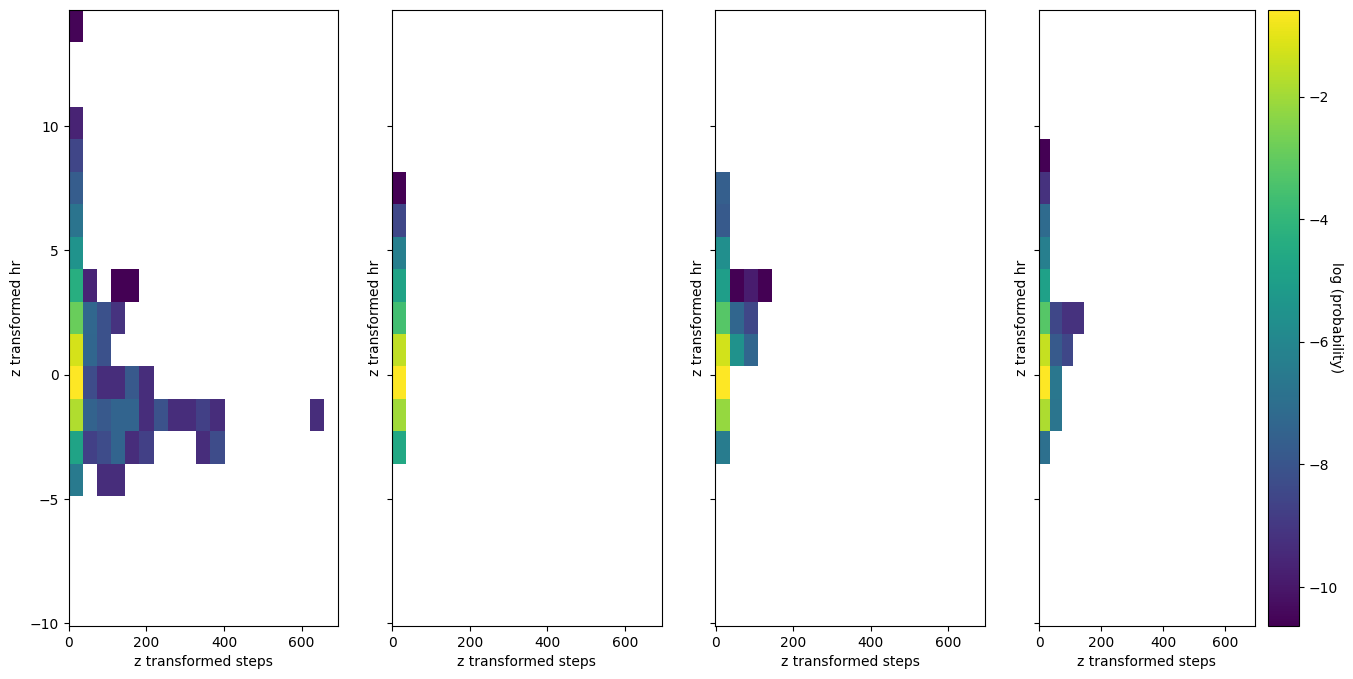

In [138]:
fig, ax = plt.subplots(1,4,figsize=(16,8),sharex = True, sharey=True)
for ph in [0,1,2,3]:
    hph = np.zeros((19,19, len(histpps)))
    for u in range(len(histpps)):
        hph[:,:,u] = histpps[u][:,:,ph]
    prob = np.nanmean(hph,axis =2)
    X, Y = np.meshgrid(xedges, yedges)
     
    im = ax[ph].pcolormesh(X, Y, np.log(prob.T ))
    ax[ph].set_xlabel('z transformed steps')
    ax[ph].set_ylabel('z transformed hr')
cbar = plt.colorbar(im);
cbar.ax.set_ylabel('log (probability)', rotation=270);

In [139]:
#fig, ax = plt.subplots(2,4,figsize=(16,8),sharex = True, sharey=True)
histpps = []
for df in s_agg:
    df['steps'] = df['steps'] - 4
    h_wind =  df[(df['week_totest'] < -2) & (df['week_totest'] > -8)]
    if len(h_wind['week_totest'].unique()) >= 2 and len(h_wind[h_wind['hr'].notna()]) >= 20:
        hrm = h_wind['hr'].mean()
        hrstd = h_wind['hr'].std()
        stm = h_wind['steps'].mean()
        ststd = h_wind['steps'].std()
        df['hr_z'] = (df['hr'] - hrm )/ hrstd
        df['steps_z'] = (df['steps'] - stm )/ ststd
        histpp = np.zeros((19,19,4))
        for ph in [0,1,2,3]:      
            dph = df[df['phase'] == ph]
            dfhist = dph[['hr_z','steps_z']].dropna()
         
            n, b = np.histogram(dfhist['hr_z'],bins = hrbin)
            #ax[0,ph].stairs(n/len(dfhist['hr_z']), hrbin, fill=False)
            
            n, b = np.histogram(dfhist['steps_z'],bins = stepbin)
            #ax[1,ph].stairs(n/len(dfhist['steps_z']), stepbin, fill=False)
            
            H, xedges, yedges = np.histogram2d(dfhist['steps_z'], dfhist['hr_z'],bins=(stepbin, hrbin),normed=True)
            areas = np.matmul(np.array([np.diff(xedges)]).T, np.array([np.diff(yedges)]))
            histpp[:,:,ph] = H*areas
        histpps.append(histpp)

/home/jovyan/datenspende-science/.venv/lib/python3.10/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in divide
  hist /= s
/home/jovyan/datenspende-science/.venv/lib/python3.10/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in divide
  hist /= s
/home/jovyan/datenspende-science/.venv/lib/python3.10/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in divide
  hist /= s
/home/jovyan/datenspende-science/.venv/lib/python3.10/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in divide
  hist /= s
/home/jovyan/datenspende-science/.venv/lib/python3.10/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in divide
  hist /= s


/tmp/ipykernel_6119/418464151.py:9: RuntimeWarning: divide by zero encountered in log
  im = ax[ph].pcolormesh(X, Y, np.log(prob.T ))


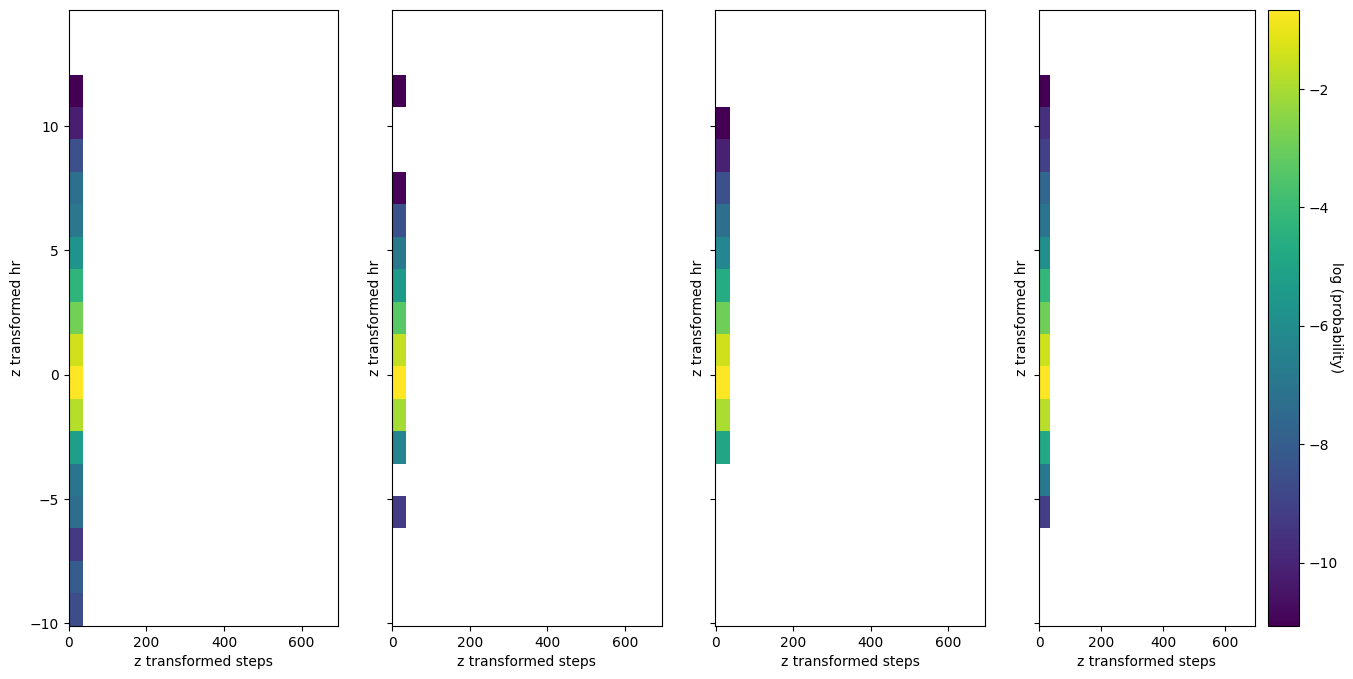

In [140]:
fig, ax = plt.subplots(1,4,figsize=(16,8),sharex = True, sharey=True)
for ph in [0,1,2,3]:
    hph = np.zeros((19,19, len(histpps)))
    for u in range(len(histpps)):
        hph[:,:,u] = histpps[u][:,:,ph]
    prob = np.nanmean(hph,axis =2)
    X, Y = np.meshgrid(xedges, yedges)
     
    im = ax[ph].pcolormesh(X, Y, np.log(prob.T ))
    ax[ph].set_xlabel('z transformed steps')
    ax[ph].set_ylabel('z transformed hr')
cbar = plt.colorbar(im);
cbar.ax.set_ylabel('log (probability)', rotation=270);